In [3]:
from Configure import Config, MakeDir
import numpy as np
import keras
import keras.backend as K
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from keras.optimizers import SGD, Adam
from utils.non_local import non_local_block
from Dataset_generator_BackgroundColor import GenerateDatasetIRNm
import sklearn
from sklearn.metrics import mean_squared_error

lr = 0.0001
m_optimizer = Adam(lr)

config = Config()

# create save folder.
MakeDir("./results/")



Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
def SavePredictedResult(dir_results, x, y, flag = 'train'):
    dim = y.shape[1]

    print(y.shape[0])
    input_test = [x[i] for i in range(config.max_obj_num)]
    input_test.append(np.ones(x[0].shape[0]))
    predict_Y = model.predict(x=input_test, batch_size=1)
    predictFile = open(dir_results + flag + "_predicted_results.txt",'w')

   # for i in range(y.shape[0]):
   #     for t in range(dim):  # save the ground_truth
    #        predictFile.write(str(y[i,t]) + '\t')
   #     predictFile.write('\n')
       # for t in range(dim):  # save the predicted results.
           # predictFile.write(str(predict_Y[i, t]) + '\t')
    #    predictFile.write('\n')
   # predictFile.close()
    
    
    MLAE = np.log2(sklearn.metrics.mean_absolute_error( predict_Y * 100, y * 100) + .125)

    return MLAE, y, predict_Y

In [5]:
def Level1_Module():
    input = Input(shape=(config.image_height, config.image_width, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = non_local_block(x)   # non local block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = non_local_block(x)   # non local block
    return Model(inputs=input, outputs=x)

# Level2 module is to compute the ratio of a pair.
# Level2 has one NON-LOCAL block.
def Level2_Module(w,h,c):
    print("Level2:", w,h,c)

    inputA = Input(shape=(w, h, c))
    inputB = Input(shape=(w, h, c))

    combined = keras.layers.concatenate([inputA, inputB])   # concatenate them.
    z = Conv2D(64, (3, 3), activation='relu',padding='same')(combined)
    z = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
    z = non_local_block(z)   # non local block
    #
    z = Flatten()(z)
    z = Dense(256, activation="relu")(z)
    z = Dropout(0.5)(z)
    z = Dense(1, activation="linear")(z)  # output the ratio of this pair.

    return Model(inputs=[inputA, inputB], outputs=z)



# IRN_m is final network to estimate the ratio vectors from multiple input instances.
def Build_IRN_m_Network():
    # input layers.
    input_layers = []
    # the first 'obj_num' inputs are corresponding to the input sub-charts.
    for i in range(config.max_obj_num):
        input = Input(shape=(config.image_height, config.image_width, 3), name="input_{}".format(i))
        input_layers.append(input)

    # The last input layer is used for representing R1=(o1/o1)=1.0 which is just a constant.
    # Here, I would use an extra input layer which is 1-dim and always equal to 1.0 rather than directly using a contant.
    # It makes same effect and can avoid some strange compile errors. (I only use TensorFlow before, not way familiar to Keras.)
    R1_one_input = Input(shape=(1,),name="input_constant_scalar1",dtype='float32')   # always equal to 1.0.
    input_layers.append(R1_one_input)

    # First extract individual features.
    individual_features = []
    level1 = Level1_Module()  # build a level1 module
    for i in range(config.max_obj_num):
        x = level1(input_layers[i])
        individual_features.append(x)

    # Use a Level2 module to predict pairwise ratios.
    level2 = Level2_Module(w=int(individual_features[0].shape[1]),
                           h=int(individual_features[0].shape[2]),
                           c=int(individual_features[0].shape[3]))

    ratio_p_layers = [R1_one_input]   # pairwise ratio vector. put in' R1=(o1/o1)=1.0 '.
    for i in range(config.max_obj_num-1): # compute the ratio of each neighbor pair.
        x = level2(inputs = [individual_features[i], individual_features[i+1]])
        ratio_p_layers.append(x)

    print("ratio_p_layers", len(ratio_p_layers), ratio_p_layers[-1].shape)

    # Compute the ratios relative to the first object by using MULTIPLY() operation.
    ratio_layers = [R1_one_input]  # put in R1=1.0.
    i = 1
    while i<len(ratio_p_layers):
        x = keras.layers.Multiply()(ratio_p_layers[:i+1])   # R1*R2*...Ri
        i+=1
        ratio_layers.append(x)

    # divide the maxinum of 'ratio_layers' to get the final results.
    max = keras.layers.maximum(ratio_layers)
    z = keras.layers.concatenate(ratio_layers)
    z = keras.layers.Lambda(lambda x: x[0]/x[1])([z, max])

    print("output layer: ", z.shape)

    return Model(inputs=input_layers, outputs=z)

In [6]:
model = Build_IRN_m_Network()


Level2: 12 12 64
ratio_p_layers 6 (?, 1)
output layer:  (?, 6)


In [7]:
model.compile(loss='mse', optimizer=m_optimizer)


In [6]:
test_num  = 20000


x_test, y_test = GenerateDatasetIRNm(flag='test', image_num=test_num)
x_test -= .5
x_test = [x_test[i] for i in range(config.max_obj_num)]
x_test.append(np.ones(test_num))  # Test_num, R1 = 1

Generating TEST Dataset: 20000 ----------------
   id 0 (obj_num = 3)
   id 5000 (obj_num = 3)
   id 10000 (obj_num = 6)
   id 15000 (obj_num = 5)
x_shape:  (6, 20000, 100, 100, 3)
y_shape:  (20000, 6)


In [8]:
model.load_weights('Bar_fixedColor_Weights.h5')

In [8]:
m_batchSize = 32            # batch_size

test_loss = model.evaluate(x_test, y_test, verbose=0, batch_size=m_batchSize)

In [9]:
test_loss

0.00010015391119522974

In [10]:
MLAE_test,y,predic_y = SavePredictedResult('results/', x_test, y_test, 'test_usingTrain')


20000


In [11]:
print(MLAE_test)

-0.5775164551856735


In [9]:

test_num  = 20000


x_test_bc, y_test_bc = GenerateDatasetIRNm(flag='test', image_num=test_num)
x_test_bc -= .5
x_test_bc = [x_test_bc[i] for i in range(config.max_obj_num)]
x_test_bc.append(np.ones(test_num))  # Test_num, R1 = 1

m_batchSize = 32            # batch_size

test_loss_bc = model.evaluate(x_test_bc, y_test_bc, verbose=0, batch_size=m_batchSize)

MLAE_test_bc,y_bc,predic_y_bc = SavePredictedResult('results/', x_test_bc, y_test_bc, 'test_usingTrain')


Generating TEST Dataset: 20000 ----------------
   id 0 (obj_num = 5)
   id 5000 (obj_num = 5)
   id 10000 (obj_num = 3)
   id 15000 (obj_num = 3)
x_shape:  (6, 20000, 100, 100, 3)
y_shape:  (20000, 6)

20000


In [10]:
MLAE_test_bc

4.883756460875016

In [13]:
%matplotlib inline 

from matplotlib import pyplot as plt

In [14]:

imgplot = plt.imshow(x_test[1][3])
plt.show()

NameError: name 'x_test' is not defined

In [19]:
i = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


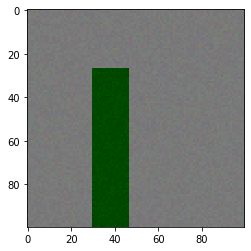

In [20]:
data = x_test[1][i]

plt.imshow(data)
plt.show()

In [ ]:
data = x_test[2][i]

plt.imshow(data)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
data = x_test[3][i]

plt.imshow(data, interpolation='nearest')
plt.show()

In [ ]:
data = x_test[4][i]

plt.imshow(data, interpolation='nearest')
plt.show()

In [ ]:
data = x_test[5][i]

plt.imshow(data, interpolation='nearest')
plt.show()